# Solving optimization problems with adiabatic quantum computation

## PPM Master, Numerical Methods Project
## Presented to you by:

### Francesco Orlaccio
### Younes Naceur
### Juan L. Santana González



### Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, sinm, cosm
from timeit import default_timer as timer

## Adiabatic Quantum Computation

An explanation of the Adiabatic Quantum Computation (AQC) concept can be found in the reference [1]. Our objective will be to implement a code to drive the general Hamiltonian $H = (1-s)H_i + sH_P$ from the initial hamiltonian $H_i$ to the final $H_P$. The ground state of the last hamiltonian is our wanted solution

### Definition of operators and constants

An adiabatic quantum computer solves the quantum version of the Ising model. The ground state of the quantum Ising model is completely analogous to its classical version, to whom the optimization problems can be mapped to. Computing the quantum hamiltonian and showing that it returns good results will prove that AQC in an actual quantum computer would yield the correct results.

The first step will be to define the quantum Ising variables, i.e., the spin operators that can be represented by the pauli matrices $\sigma_x, \sigma_y, \sigma_z$. Then, the states will live in a composite space  denoted $ V = U_1\otimes U_2 \otimes ··· \otimes U_N$, where $U_i$ is the space of 2x2 matrices and $N$ the number of Ising variables.

In [2]:
# Define the sigma matrices

sx = np.array([[0,1],[1,0]])

sy = np.array([[0,-1j],[1j,0]])

sz = np.array([[1,0],[0,-1]])

ide = np.array([[1,0],[0,1]])


The i-th spin operator represented by the pauli matrices will have the form $\vec{S_i} = \mathbb{1}_{2\times2} \otimes  ···\otimes\mathbb{1}_{2\times2} \otimes \vec{\sigma}_i \otimes \mathbb{1}_{2\times2} \otimes ··· \otimes\mathbb{1}_{2\times2} $. We implement the operator in the function tensormat(), which will alow us to compute the Ising hamiltonians.

In [3]:
# Define the tensor product

def tensor(a,b):
    return np.kron(b,a)

# Build the tensor product 1 x 1 x .... sz x 1 -> Matrix acting on i-th position



def tensormat(i,n,s):
    ## Arguments: i: Position at which the sigma matrix is inserted; 
    ## s: applied pauli matrix;
    ## n: Number of spins
    
    if(i == 0):
        t = s
        for j in range(1,n):
            t = tensor(t,ide)
    else:      
        t = ide
        for j in range(1,n):
            if(j == i):
                t = tensor(t,s)
            else:
                t = tensor(t,ide)
    return t
            

Finally, we will consider our initial Hamiltonian to be the transverse field hamiltonian, where we consider all spins oriented in the x direction: $ H_i = \frac{1}{N}\sum_i \sigma_i^x $. The ground state of this hamiltonian is known precisely, the energy being $ E = -1 $, and the quantum state being $ |g.s.\rangle = |s\rangle \otimes ··· \otimes |s\rangle$. Here, $|s \rangle = \frac{1}{\sqrt{2}} (|+ \rangle-|- \rangle)$ is the eigenstate for a single spin oriented towards the x axis, expressed in the basis of eigenstates of $\sigma_z$.

In [4]:
# Ising model formulation: We start in the ground state of the transverse field hamiltonian

# Define single ground state vector
gsx = 1/(np.sqrt(2))*np.array([1,-1])

# Define function giving the coupled ground state vector
def coupledgs(n):
    gs = gsx
    for i in range(n-1):
        gs = tensor(gs,gsx)
    return gs

### Definition of Hamiltonians

First we define the initial hamiltonian $H_i$ and the intermediate hamiltonian $H(s)$. To take te numerical approach, we need to discretize the $s$ parameter that determines the evolution from $H_i$ to $H_P$, $s = \frac{idt}{T}$. We will use this function to compute the intermediate hamiltonian in every timestep:

In [5]:
# Define function giving us the initial Hamiltonian
def trans_ham(n):
    ## Initial hamiltonian for n spins
    return 1/n*sum([tensormat(i,n,sx) for i in range(n)]) # Factor 1/n for normalization

# Define the intermediate Hamiltonian for AQC, defined by dimensionless parameter s
def interm_ham(H0,H1,s):
    if(s > 1 or s < 0):
        print("Parameter s is not in the range between 0 and 1!")
        return
    else:
        return (1-s)*H0+s*H1

We will also need the time evolution operator, to make our initial ground eigenstate change at every time step. This operator is defined as $U(t) = e^{-iH(s)t}$, such that any quantum state evolves as $|\psi(t)\rangle = U(s) |\psi\rangle$

In [6]:
# Define the time evolution operator of a Hamiltonian
def time_evo(H,t):
    return expm(-1j*H*t) # Here we set hbar = 1

Now, we will implement the optimization hamiltonians. These hamiltonians are constructed by mapping the optimization problem into a classical ising hamiltonian (variables +1 and -1.) As said, we solve the analogous quantum version to show that AQC is valid. More information on the mapping hamiltonians can be found in [2].

#### Number Partition

In [7]:
#### Hamiltonian for number partioning problem

def numpart_ham(n,nums,A):
    ## n = number of values
    ## nums = array with values
    ## A = normalization constant
    if(n != len(nums)):
        print("Length of number array and number of spins is not the same!")
        return
    
    # Define "unsquared" Hamiltonian
    ham_unsq = sum([nums[i]*tensormat(i,n,sz) for i in range(n)])
    return A*np.matmul(ham_unsq,ham_unsq)

 # Now: Define function that checks if at least one eigenvalue of the number partition hamiltonian is zero,
# or in other words, if the array is partitionable

def partitionable(H,n):
    for i in range(n):
        if(H[i][i] == 0):
            return True
    return False


#### Exact Covering

In [8]:
#### Hamiltonian for the exact covering problem

def excov_ham(u,v,A):
    n = len(u)
    H = np.zeros((2**n,2**n))
    ID = tensormat(0,n,ide)
    for alpha in range(n):
        alphasum = np.zeros((2**n,2**n))
        for i in range(len(v)):
            if(u[alpha] in v[i]):
                alphasum += tensormat(i,n,sz)
        Hsummand = np.matmul(ID-alphasum,ID-alphasum)
        H += A*Hsummand
    return H

#### Graph partition

In [9]:
#### Hamiltonians for Graph partitioning

## Interaction on 1st Neighbours with periodic boundary conditions

def graphpart_1stNeigham(n,A,B):
    
    ## We neglect the rest of interactions in order to speed up the calculations
    ## n = number of spins
    ## A = Energy penalization for a nonequal number of nodes in each group
    ## B = Interaction energy with 1st Neighbours (If B> 0 the interaction is repulsive, If B<0 the interaction is attractive)
    sqrtHA = sum((tensormat(i,n,sz) for i in range(n)))
    HA = A * np.matmul(sqrtHA,sqrtHA) ## Penalization hamiltonian
    S = 0
    ID = tensormat(0,n,ide) ## Identity definition
    if n == 2: # If we only have two spins, the interaction energy is half as the general case
        S = (ID-np.matmul(tensormat(0,n,sz),tensormat(1,n,sz)))
        HB = B*S*1/2
    else:
        for j in range(0,n):
            
            for k in range(j-1,j+2):
            
                if k == j:
                    continue           
                if k == -1:
                    S += (ID-np.matmul(tensormat(j,n,sz),tensormat(n-1,n,sz))) 
                if k == n:
                    S += (ID-np.matmul(tensormat(j,n,sz),tensormat(0,n,sz)))
                else:
                    S += (ID-np.matmul(tensormat(j,n,sz),tensormat(k,n,sz))) 
        HB = B*S*1/4
    return HA + HB


In [10]:
## Interaction with 2nd neighbours

def graphpart_2sndNeigham(n,A,B,C):
    
    ## Analogous to the 1st neighbours but with C being the interaction energy with 2nd neighbours

    sqrtHA = sum((tensormat(i,n,sz) for i in range(n)))
    HA = A * np.matmul(sqrtHA,sqrtHA)
    HB = 0
    HC = 0
    
    ID = tensormat(0,n,ide)
    if n == 2:
        S = (ID-np.matmul(tensormat(0,n,sz),tensormat(1,n,sz)))
        HB = B*S*1/2
    
    if n == 2 or n == 3: ## No 2nd neighbours interaction is possible in this cases
        HC = 0
        
    elif n ==4: ## Analogous to the N =2 case of 1st neighbours, if we have only 4 spins, the 2nd Neightbours interaction is half
        for j in range(0,n):
            
            for k in range(j-2,j+3):
                if k == j-1 or k == j or k == j+1:
            
                    if k == j:
                        continue           
                    if k == -1:
                        HB += 1/4*B*(ID-np.matmul(tensormat(j,n,sz),tensormat(n-1,n,sz))) 
                    if k == n:
                        HB += 1/4*B*(ID-np.matmul(tensormat(j,n,sz),tensormat(0,n,sz)))
                    else:
                        HB += 1/4*B*(ID-np.matmul(tensormat(j,n,sz),tensormat(k,n,sz)))
                else:
                    HC += 1/8*C*(ID-np.matmul(tensormat(j,n,sz),tensormat(k,n,sz)))
    
    else:
        for j in range(0,n):
            
            for k in range(j-2,j+3):
                if k == j-1 or k == j or k == j+1:
            
                    if k == j:
                        continue           
                    if k == -1:
                        HB += 1/4*B*(ID-np.matmul(tensormat(j,n,sz),tensormat(n-1,n,sz))) 
                    if k == n:
                        HB += 1/4*B*(ID-np.matmul(tensormat(j,n,sz),tensormat(0,n,sz)))
                    else:
                        HB += 1/4*B*(ID-np.matmul(tensormat(j,n,sz),tensormat(k,n,sz))) 
                else:
                    if k == -2:
                        HC += 1/4*C*(ID-np.matmul(tensormat(j,n,sz),tensormat(n-2,n,sz))) 
                    if k == n+1:
                        HC += 1/4*C*(ID-np.matmul(tensormat(j,n,sz),tensormat(1,n,sz)))
                    else:
                        HC += 1/4*C*(ID-np.matmul(tensormat(j,n,sz),tensormat(k,n,sz)))
    
    return HA + HB + HC


### Performing the adiabatic quantum evolution

Finally, we implement the evolution of the ground state of the transverse field hamiltonian ($H_i$) for a given number $M$ of intermediate hamiltonians, and compute it for a total time $T$. To do this, we apply the evolution operator to the ground state for every time step, where the hamiltonian producing the evolution is the intermediate one (and it changes for every time step). The number of intermediate steps must be chosen carefully in order to maintain the system in the ground state and avoid unwanted transititions.

In [11]:
#### Evolution implementation
## All of them act in the same way, only differing in the final hamiltonian H_P
## n = number of spins
## M = number of intermediate hamiltonians (number of steps)
## T = total time of evolution
## A = normalization constant

def aqc_numpart(n,M,T,nums,A):
    state = coupledgs(n)
    dt = T/M
    HP = numpart_ham(n,nums,A)
    HI = trans_ham(n)
    hamiltonians = [interm_ham(HI,HP,i*1/M) for i in range(M+1)]
    for i in range(M+1):
        state = np.matmul(time_evo(hamiltonians[i],dt),state)
    s1 = np.matmul(HP,state)
    E = np.matmul(state.transpose().conjugate(),s1)
    return E, state

def aqc_excov(M,T,u,v,A):
    n = len(u)
    state = coupledgs(n)
    dt = T/M
    HP = excov_ham(u,v,A)
    HI = trans_ham(n)
    hamiltonians = [interm_ham(HI,HP,i*1/M) for i in range(M+1)]
    for i in range(M+1):
        state = np.matmul(time_evo(hamiltonians[i],dt),state)
    s1 = np.matmul(HP,state)
    E = np.matmul(state.transpose().conjugate(),s1)
    return E, state

def aqc_graphpart1stNeigh(n,M,T,A,B):
    state = coupledgs(n)
    dt = T/M
    HP = graphpart_1stNeigham(n,A,B)
    HI = trans_ham(n)
    hamiltonians = [interm_ham(HI,HP,i*1/M) for i in range(M+1)]
    for i in range(M+1):
        state = np.matmul(time_evo(hamiltonians[i],dt),state)
    s1 = np.matmul(HP,state)
    E = np.matmul(state.transpose().conjugate(),s1)
    return E, state

def aqc_graphpart2ndNeig(n,M,T,A,B,C):
    state = coupledgs(n)
    dt = T/M
    HP = graphpart_2sndNeigham(n,A,B,C)
    HI = trans_ham(n)
    hamiltonians = [interm_ham(HI,HP,i*1/M) for i in range(M+1)]
    for i in range(M+1):
        state = np.matmul(time_evo(hamiltonians[i],dt),state)
    s1 = np.matmul(HP,state)
    E = np.matmul(state.transpose().conjugate(),s1)
    return E, state


## Results and discussion

We present some general results with low number of spins for the chosen optimization problems.

### Performance of the method

To check the performance of the algorithm and its dependence on $M$ and $T$, we use the simplest optimization problem, which is the number partitioning, and we compute the final energy of a simple partitionable array $[1,2,3]$ with zero ground state energy. Therefore, if the algorithm suceeds, and we stay in the ground state for all times, we expect to find $E = 0$. For $M$ or $T$ too low, we observe that the final energy is non zero, which implies that transitions to higher excited states occured during the calculation.

C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


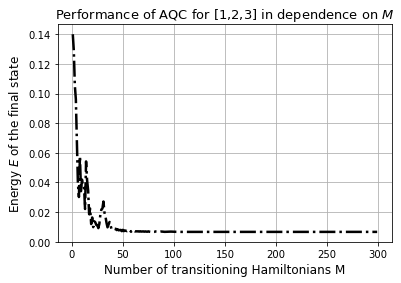

In [12]:
# Define the number of Hamiltonians we're transitioning through
ms = np.arange(1,300,1)

# Define a list with the ground state energy of the (partitionable) problem
energies = [aqc_numpart(3,i,500,[1,2,3],0.01)[0] for i in ms]

# Plot the dependence of the gs energy with respect to M
plt.plot(ms,energies,linestyle='dashdot',color='k',linewidth=2.5)
plt.xlabel('Number of transitioning Hamiltonians M',fontsize=12)
plt.ylabel(r'Energy $E$ of the final state',fontsize=12)
plt.title(r'Performance of AQC for [1,2,3] in dependence on $M$',fontsize=13)
plt.grid()
plt.savefig("nummet_mdependence.jpg")
plt.show()

C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


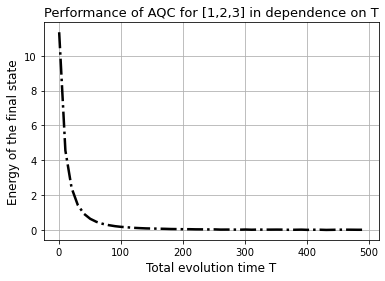

In [13]:
# Define an array with the total evolution times T
times = np.arange(1,500,10)

# Calculate the final ground state energy with AQC for the different total evolution times
energies = [aqc_numpart(3,500,t,[1,2,3],1)[0] for t in times]

# Plot the results
plt.plot(times,energies,linestyle='dashdot',color='k',linewidth=2.5)
plt.xlabel('Total evolution time T',fontsize=12)
plt.ylabel('Energy of the final state',fontsize=12)
plt.title('Performance of AQC for [1,2,3] in dependence on T',fontsize=13)
plt.grid()
plt.savefig("nummet_tdependence.jpg")

### Number Partitioning

See section 2.1 of reference [2].

C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


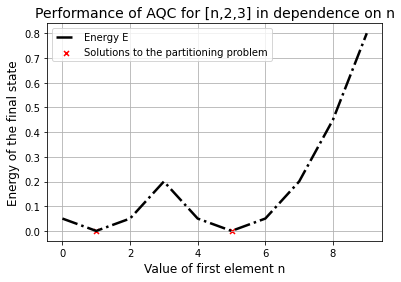

In [14]:
sval = np.arange(0,10,1)
energies = [aqc_numpart(3,700,500,[s,2,3],0.05)[0] for s in sval]
plt.plot(sval,energies,linestyle='dashdot',color='k',linewidth=2.5,label='Energy E')
plt.xlabel('Value of first element n',fontsize=12)
plt.ylabel('Energy of the final state',fontsize=12)
plt.title('Performance of AQC for [n,2,3] in dependence on n',fontsize=14)
plt.scatter([1,5],[0,0],color='r',label='Solutions to the partitioning problem',marker='x',s=25)
plt.legend()
plt.grid()
plt.savefig("nummet_ndependence.jpg")

C:\Users\Usuario\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


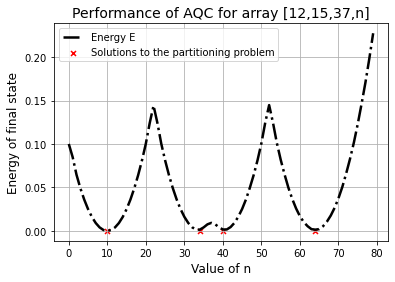

In [15]:
iarray = np.arange(0,80,1)
narray = [aqc_numpart(4,500,500,[12,15,37,i],1e-3)[0] for i in iarray]
plt.plot(iarray,narray,linewidth = 2.5,linestyle='dashdot',color='k',label='Energy E')
plt.ylabel('Energy of final state',fontsize=12)
plt.xlabel('Value of n',fontsize=12)
plt.title('Performance of AQC for array [12,15,37,n]',fontsize=14)
plt.scatter([10,34,40,64],[0,0,0,0],color='r',label='Solutions to the partitioning problem',marker='x',s=25)
plt.legend()
plt.grid()
plt.savefig('nummet_fourdarray.jpg')

### Exact cover

See section 4.1 of [2].

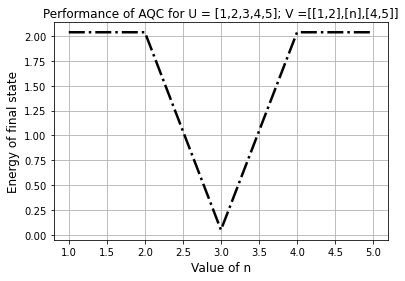

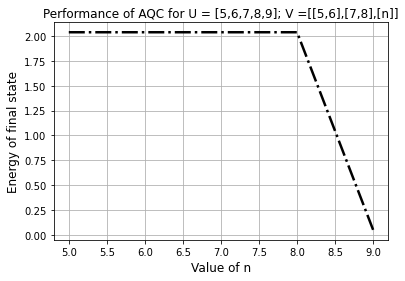

In [16]:

u1 = [1,2,3,4,5]
energies1 = [aqc_excov(300,500,u1,[[1,2],[i],[4,5]],1)[0] for i in u1]

# Show the results
plt.plot(u1,energies1,linewidth=2.5,color='k',linestyle='dashdot')
plt.xlabel('Value of n',fontsize=12)
plt.ylabel('Energy of final state',fontsize=12)
plt.title(r'Performance of AQC for U = [1,2,3,4,5]; V =[[1,2],[n],[4,5]]')
plt.grid()
plt.savefig("nummet_exactcov1.jpg")
plt.show()

# Another example with a different set of numbers
            
u2 = [5,6,7,8,9]
energies2 = [aqc_excov(300,500,u2,[[5,6],[7,8],[i]],1)[0] for i in u2]

plt.plot(u2,energies2,linewidth=2.5,color='k',linestyle='dashdot')
plt.xlabel('Value of n',fontsize=12)
plt.ylabel('Energy of final state',fontsize=12)
plt.title(r'Performance of AQC for U = [5,6,7,8,9]; V =[[5,6],[7,8],[n]]')
plt.grid()
plt.savefig("nummet_exactcov2.jpg")
plt.show()

### Graph partitioning

In this first result, for 1st Neighbours, we show that our method yields good results to the energy for low number of spins. The results only begin to deviate from N = 7, due to the high cost of the calculation, which is based on the multiplication of $2^N \times 2^N$ matrices.

In [17]:
A = 1
X = np.zeros((5,20))
B = np.linspace(0.1,3,20)
N = [2,3,4,5,6]
for n, val in enumerate(N):
    for j,i in enumerate(X[n,:]):
        X[n,j] = aqc_graphpart1stNeigh(val,100,100,1,B[j])[0]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\2635267489.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  X[n,j] = aqc_graphpart1stNeigh(val,100,100,1,B[j])[0]


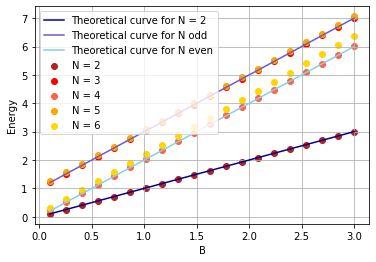

In [18]:
import matplotlib.colors as mcol

plt.plot(B,B, c="darkblue", label = "Theoretical curve for N = 2")
plt.plot(B,A+2*B, c="slateblue", label = "Theoretical curve for N odd")
plt.plot(B,2*B, c="skyblue", label = "Theoretical curve for N even")
plt.scatter(B,X[0,:], c= "firebrick", label = "N = 2")
plt.scatter(B,X[1,:], c="red", label = "N = 3")
plt.scatter(B,X[2,:], c="tomato", label = "N = 4")
plt.scatter(B,X[3,:], c="orange", label = "N = 5")
plt.scatter(B,X[4,:], c="gold", label = "N = 6")
plt.ylabel("Energy")
plt.xlabel("B")
plt.legend()
plt.grid()


We can also see that the eigenstate is explicitly found. For example, consider N = 3, the eigenbase used for the initial eigenstate is $\lgroup |+++\rangle,|++-\rangle,|+-+\rangle,|+--\rangle,|-++\rangle,|-+-\rangle,|--+\rangle,|---\rangle \rgroup$ .The eigenstate cannot be the states at the extremes, it must be a linear combination of the other 6. We find a correct eigenstate in the position, and with a good normalization. However, we can never get rid of the natural degeneracy of the ising model, so the result is just one option of many. Our result in the case is the state:

$ | g.s. \rangle = c(-|++-\rangle-|+-+\rangle+|+--\rangle-|-++\rangle+|-+-\rangle+|--+\rangle)$ with $c = 0.10312645-0.39482577i \longrightarrow |c|^2 \simeq \frac{1}{\sqrt{6}}$

In [19]:

state = aqc_graphpart2ndNeig(3,100,100,1,1,0)[1]
print("The state is a linear combination of the initial eigenstates : " )
print(str(state))
print(r"$\langle \g.s. | g.s. \rangle = $")
print(r" $ \sigma $ ")
print(str(np.matmul(state.transpose().conjugate(),state)))

The state is a linear combination of the initial eigenstates : 
[ 0.01834433+0.00980476j -0.10312645-0.39482577j -0.10312645-0.39482577j
  0.10312645+0.39482577j -0.10312645-0.39482577j  0.10312645+0.39482577j
  0.10312645+0.39482577j -0.01834433-0.00980476j]
$\langle \g.s. | g.s. \rangle = $
 $ \sigma $ 
(0.9999999999999988+0j)


As a remark, A and B need to be chosen according to the condition $\frac{A}{B} \ge \frac{\min(2\Delta,N)}{8}$, where $ \Delta = 1$ if $N = 2$ and $\Delta = 2$ if $N>2$  (See reference []). Although we check that for a variation of B the result doesn't deviate too much, for choosing A this relation is very important, as we see in the second graph below. The calculation breaks much more quickly, so this is the parameter to look after.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\4057958546.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  X[j] = aqc_graphpart1stNeigh(5,100,100,1,B[j])[0]


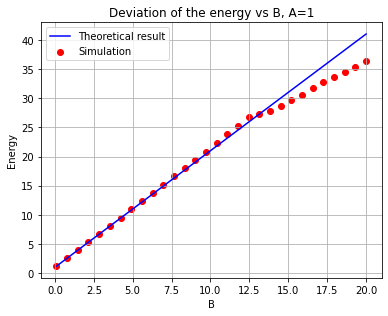

In [32]:
A = 1
X = np.zeros(30)
B = np.linspace(0.1,20,30)
for j,i in enumerate(X):
    X[j] = aqc_graphpart1stNeigh(5,100,100,1,B[j])[0]

plt.title("Deviation of the energy vs B, A=1")
plt.ylabel("Energy")
plt.xlabel("B")
plt.plot(B,A+2*B, c="b", label ="Theoretical result")
plt.scatter(B,X, c="red" , label = "Simulation")
plt.legend()
plt.grid()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\2416515738.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  X[j] = aqc_graphpart1stNeigh(5,100,100,A[j],B)[0]


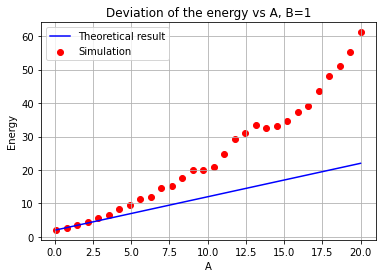

In [21]:
B = 1
X = np.zeros(30)
A = np.linspace(0.1,20,30)
for j,i in enumerate(X):
    X[j] = aqc_graphpart1stNeigh(5,100,100,A[j],B)[0]

plt.plot(A,A+2*B, c="b",label ="Theoretical result")
plt.scatter(A,X, c="red" , label ="Simulation")
plt.title("Deviation of the energy vs A, B=1")
plt.legend()
plt.ylabel("Energy")
plt.xlabel("A")
plt.grid()

The error increases with the number of Ising variables. However, we are unable to fit the curve to an exponential or a polynomial (as the matrix multiplication). We would need more points for a better accuracy:

In [22]:
### Relative Energy vs N
## Warning, this computation takes 5 minutes approxim
N = np.arange(2,11)
A = 1
B = 2

X = np.zeros(len(N))

ErrN = np.zeros(len(N))

for n in range(0,len(N)):
    X[n] = aqc_graphpart1stNeigh(N[n],100,100,A,B)[0]

    if N[n] == 2:
        ErrN[n] = np.abs(X[n]- B)/B
    elif (N[n]%2) == 0.:
        ErrN[n] = np.abs(X[n]- 2*B)/2*B
    else:
        ErrN[n] = np.abs(X[n]- (A+2*B))/(A+2*B)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\4218708533.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  X[n] = aqc_graphpart1stNeigh(N[n],100,100,A,B)[0]


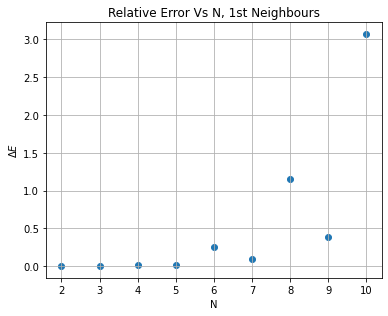

In [23]:

plt.rcParams["figure.figsize"] = [5.50, 4.50]
plt.rcParams["figure.autolayout"] = True
plt.scatter(N,ErrN)
plt.title("Relative Error Vs N, 1st Neighbours")
plt.xlabel("N")
plt.ylabel(r"$\Delta E$")
plt.grid()
plt.savefig("RelativeEnergy1stNeighbours.png")

In the case of adding interactions to second neighbours, we also reproduce the desired results, but the deviations increase more rapidly. In this case we choose N = 5 because is fast and offers good results. We also need to be aware that a new relation between A, B and C must be taken into an account in order for the results to be precise. The first result show that C must be small compared to A and B:

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\4201224178.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  X[j] = aqc_graphpart2ndNeig(5,100,100,A,B[b],C[j])[0]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\4201224178.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  X[j] = aqc_graphpart2ndNeig(5,100,100,A,B[b],C[j])[0]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\4201224178.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  X[j] = aqc_graphpart2ndNeig(5,100,100,A,B[b],C[j])[0]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\4201224178.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  X[j] = aqc_graphpart2ndNeig(5,100,100,A,B[b],C[j])[0]


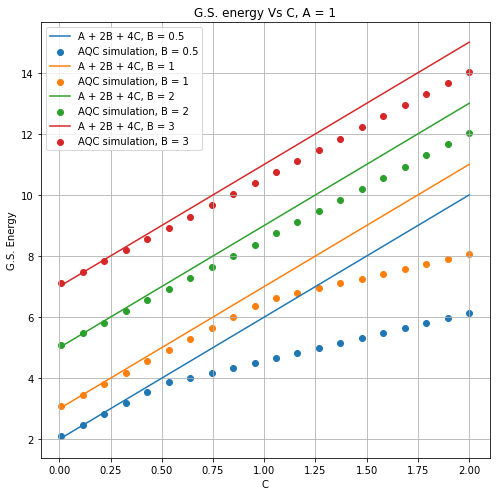

In [24]:
plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True
A = 1
B = [0.5,1,2,3]
X = np.zeros(20)
C = np.linspace(0.01,2,20)
for b, bval in enumerate(B):
    for j,i in enumerate(X):
        X[j] = aqc_graphpart2ndNeig(5,100,100,A,B[b],C[j])[0]

    plt.plot(C,1+2*B[b] + 4*C, label = "A + 2B + 4C, B = " + str(B[b]))
    plt.scatter(C,X, label = "AQC simulation, B = " + str(B[b]))

plt.xlabel("C")
plt.ylabel("G.S. Energy")
plt.legend()
plt.title("G.S. energy Vs C, A = 1")
plt.grid()


From here, we infer that, for similar $A$ and $B$, C must be around 0.25 at maximum, in order to have an acceptable result. This could be a logical result for physical systems for example, where the interactions decrease with the distance.

However, the system is still highly sensitive on A:

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\2579886404.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  X[j] = aqc_graphpart2ndNeig(5,100,100,A,B[b],C[j])[0]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\2579886404.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  X[j] = aqc_graphpart2ndNeig(5,100,100,A,B[b],C[j])[0]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\2579886404.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  X[j] = aqc_graphpart2ndNeig(5,100,100,A,B[b],C[j])[0]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\2579886404.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  X[j] = aqc_graphpart2ndNeig(5,100,100,A,B[b],C[j])[0]


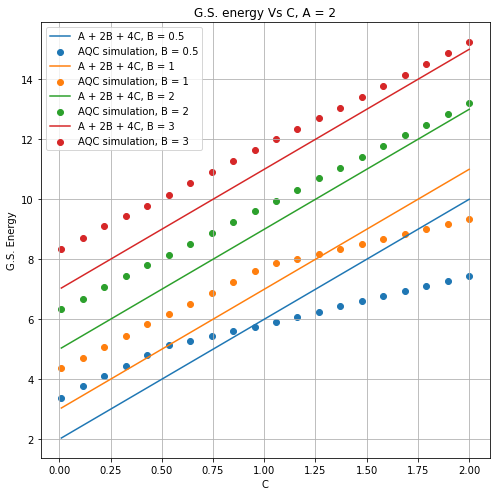

In [25]:
A = 2
B = [0.5,1,2,3]
X = np.zeros(20)
C = np.linspace(0.01,2,20)
for b, bval in enumerate(B):
    for j,i in enumerate(X):
        X[j] = aqc_graphpart2ndNeig(5,100,100,A,B[b],C[j])[0]

    plt.plot(C,1+2*B[b] + 4*C, label = "A + 2B + 4C, B = " + str(B[b]))
    plt.scatter(C,X, label = "AQC simulation, B = " + str(B[b]))

plt.xlabel("C")
plt.ylabel("G.S. Energy")
plt.legend()
plt.title("G.S. energy Vs C, A = 2")
plt.grid()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\1883656105.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  X[j] = aqc_graphpart2ndNeig(5,100,100,A,B[b],C[j])[0]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\1883656105.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  X[j] = aqc_graphpart2ndNeig(5,100,100,A,B[b],C[j])[0]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\1883656105.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  X[j] = aqc_graphpart2ndNeig(5,100,100,A,B[b],C[j])[0]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\1883656105.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  X[j] = aqc_graphpart2ndNeig(5,100,100,A,B[b],C[j])[0]


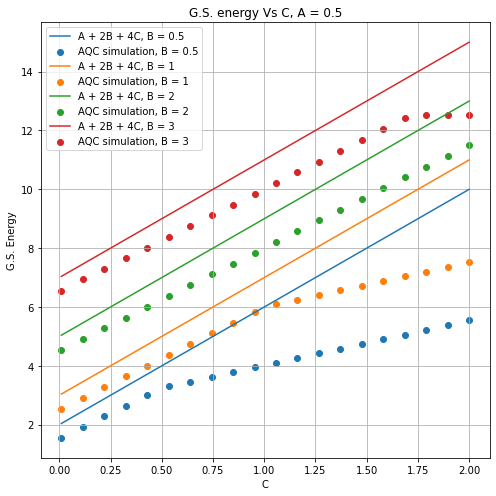

In [26]:
A = 0.5
B = [0.5,1,2,3]
X = np.zeros(20)
C = np.linspace(0.01,2,20)
for b, bval in enumerate(B):
    for j,i in enumerate(X):
        X[j] = aqc_graphpart2ndNeig(5,100,100,A,B[b],C[j])[0]

    plt.plot(C,1+2*B[b] + 4*C, label = "A + 2B + 4C, B = " + str(B[b]))
    plt.scatter(C,X, label = "AQC simulation, B = " + str(B[b]))

plt.xlabel("C")
plt.ylabel("G.S. Energy")
plt.legend()
plt.title("G.S. energy Vs C, A = 0.5")
plt.grid()

To really convince ourselves, we can construct a 3d object with the values of the energy with B and C as axis, and compare with the plane where the theoretical solutions live, $f(B,C) = A + 2B + 4C$ :

In [27]:
A = 1
B = np.linspace(0,4,30)
C = np.linspace(0,4,30)
en = np.ndarray((30,30))
for j in range(30):
    for k in range(30):
        en[j,k] = aqc_graphpart2ndNeig(5,100,100,A,B[j],C[k])[0]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\1219317824.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  en[j,k] = aqc_graphpart2ndNeig(5,100,100,A,B[j],C[k])[0]


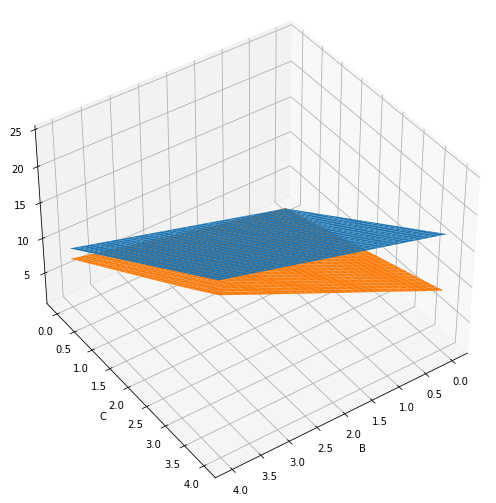

<Figure size 720x720 with 0 Axes>

In [28]:
## Extended study for the dependance of the parameters A, B, C
plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True
B = np.linspace(0,4,30)
C = np.linspace(0,4,30)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

B,C = np.meshgrid(B,C)

plt.figure(figsize=(10,10))


f = A+2*B+4*C

ax.plot_surface(B,C,f, facecolor="blue",label="theory")

ax.plot_surface(B,C,en, facecolor="red", label="simulation")
ax.set_xlabel("B")
ax.set_ylabel("C")

# plt.legend()
ax.view_init(40, 55)

plt.show()


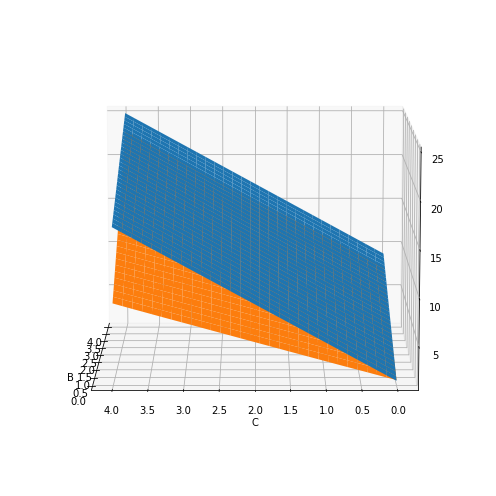

<Figure size 720x720 with 0 Axes>

In [29]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plt.figure(figsize=(10,10))

ax.plot_surface(B,C,f, facecolor="blue",label="theory")

ax.plot_surface(B,C,en, facecolor="red", label="simulation")
ax.set_xlabel("B")
ax.set_ylabel("C")

# plt.legend()
ax.view_init(10, 180)

plt.show()

Here we see, if $B = 0$, the calculation is very bad. If $C$ is similar to $B$, we also have big deviations. The acceptable solutions come for $C<<B$ and $B$ similar to $A$, which is equal to 1 here. However, $B$ shouldn't exceed $A$ too much, or we also start to deviate.

Finally, we fit the parameters with a good relation between them and we observe that the deviations increase in function of N, as expected. However, we cannot say if the growth is exponential or polynomial (as the matrix multiplication), as we would need more points:

In [30]:
## Warning, this calculation takes approximately 5 minutes
N = np.arange(4,11)
A = 1
B = 2
C = 0.2
X = np.zeros(len(N))

ErrN = np.zeros(len(N))

for n in range(0,len(N)):
    X[n] = aqc_graphpart2ndNeig(N[n],100,100,A,B,C)[0]

    if N[n] == 4:
        ErrN[n] = np.abs(X[n]- (2*B+2*C))/(2*B+2*C)
    elif (N[n]%2) == 0.:
        ErrN[n] = np.abs(X[n]- (2*B+4*C))/(2*B+4*C)
    else:
        ErrN[n] = np.abs(X[n]- (A+2*B+4*C))/(A+2*B+4*C)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8972\2746495061.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  X[n] = aqc_graphpart2ndNeig(N[n],100,100,A,B,C)[0]


An interesting remark is that the Energy seems to be more precise with the inclusion of 2nd Neighbours. This in logical, as for larger N more interactions are needed to fully describe the system correctly.

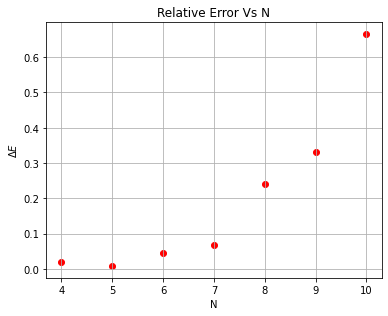

In [31]:
plt.rcParams["figure.figsize"] = [5.50, 4.50]
plt.rcParams["figure.autolayout"] = True
plt.scatter(N,ErrN, c="red")
plt.title("Relative Error Vs N")
plt.xlabel("N")
plt.ylabel(r"$\Delta E$")
plt.grid()
plt.savefig("EnergyVsN2ndNeighbours.png")

To finish, we propose some further considerations for this problem. For example, if the interactions are choosing carefully, this system could simulate an actual Ising physical spin system. In this situations we can also consider negative parameters, for example $A<0$ would infer a ferromagnetic system, and $B,C<0$ would infer atractive interactions. The results of an actual adiabatic quantum computer for large N could be extrapolated to a very large number of different applications, such as geographical connections, social media networks and interactions, etc. This is a rapidly developing field, from which we will hear surely in the future.

## References

[1] https://www.cs.umd.edu/~amchilds/talks/cifar13-tutorial.pdf

[2] Lucas, A. (2014). Ising formulations of many NP problems. Frontiers in Physics, 2. https://doi.org/10.3389/fphy.2014.00005